In [1]:
%run _standard_imports.ipynb
%run _plotting_setup.ipynb


python 3.5.2 |Continuum Analytics, Inc.| (default, Jul  2 2016, 17:53:06) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
numpy 1.11.2
scipy 0.18.1
pandas 0.19.0
numexpr 2.6.1
pysam 0.8.4
petl 1.1.0
petlx 1.0.3
vcf 0.6.8
vcfnp 2.2.0
h5py 2.6.0
tables 3.3.0


In [2]:
output_dir = '/lustre/scratch111/malaria/rp7/data/methods-dev/builds/Pf6.0/20161128_HDF5_build'
vrpipe_fileinfo_fn = "%s/pf_60_genotype_gvcfs_200kb.txt" % output_dir
vcf_fofn = "%s/pf_60_genotype_gvcfs_200kb.fofn" % output_dir
vcf_stem = '/lustre/scratch109/malaria/rp7/data/methods-dev/builds/Pf6.0/20161125_Pf60_final_vcfs/vcf/Pf_60_{chrom}.final.vcf.gz'

nfs_release_dir = '/nfs/team112_internal/production/release_build/Pf/6_0_release_packages'
nfs_final_hdf5_dir = '%s/hdf5' % nfs_release_dir
!mkdir -p {nfs_final_hdf5_dir}

GENOME_FN = "/lustre/scratch116/malaria/pfalciparum/resources/Pfalciparum.genome.fasta"
genome_fn = "%s/Pfalciparum.genome.fasta" % output_dir

!mkdir -p {output_dir}/hdf5
!mkdir -p {output_dir}/vcf
!mkdir -p {output_dir}/npy
!mkdir -p {output_dir}/npy_no_PID_PGT
!mkdir -p {output_dir}/npy_PL_28
!mkdir -p {output_dir}/scripts
!mkdir -p {output_dir}/log

!cp {GENOME_FN} {genome_fn}

In [3]:
genome = pyfasta.Fasta(genome_fn)
genome

In [18]:
fo = open("%s/scripts/vcfnp_variants_no_PID_PGT.sh" % output_dir, 'w')
print('''#!/bin/bash

#set changes bash options
#x prints commands & args as they are executed
set -x
#-e  Exit immediately if a command exits with a non-zero status
set -e
#reports the last program to return a non-0 exit code rather than the exit code of the last problem
set -o pipefail

vcf=$1
chrom=$2

fasta=%s

# Reasons for some of string lengths
# REF and ALT: found an SV with length -192 in one small test chunk, so decided on 300bp as this is a typical insert size
# SNPEFF_AMINO_ACID_CHANGE: maximum 300 bases, therefore 100 alt AA + 1 ref AA + 4 integers for position 
# SNPEFF_CODON_CHANGE: # maximum 300 alt bases + 3 ref bases + "/"
# SNPEFF_EXON_ID: integer for exon number, but kept as string in case any else in there 

vcf2npy \
    --vcf $vcf \
    --fasta $fasta \
    --output-dir %s/npy_no_PID_PGT \
    --array-type variants \
    --task-size 20000 \
    --task-index LSB_JOBINDEX \
    --progress 1000 \
    --chromosome $chrom \
    --arity ALT:6 \
    --arity AF:6 \
    --arity AC:6 \
    --arity svlen:6 \
    --dtype REF:a300 \
    --dtype ALT:a300 \
    --dtype MULTIALLELIC:a2 \
    --dtype RegionType:a25 \
    --dtype SNPEFF_AMINO_ACID_CHANGE:a105 \
    --dtype SNPEFF_CODON_CHANGE:a304 \
    --dtype SNPEFF_EFFECT:a33 \
    --dtype SNPEFF_EXON_ID:a2 \
    --dtype SNPEFF_FUNCTIONAL_CLASS:a8 \
    --dtype SNPEFF_GENE_NAME:a20 \
    --dtype SNPEFF_IMPACT:a8 \
    --dtype SNPEFF_TRANSCRIPT_ID:a20 \
    --dtype VARIANT_TYPE:a5 \
    --dtype VariantType:a40 \
    --exclude-field ID''' % (
        genome_fn,
        output_dir,
        )
        , file=fo)
fo.close()


In [19]:
fo = open("%s/scripts/vcfnp_calldata_no_PID_PGT.sh" % output_dir, 'w')
print('''#!/bin/bash

set -x
set -e
set -o pipefail

vcf=$1
chrom=$2

fasta=%s

# Reasons for some of string lengths
# PL: number of PLs is n(n+1)/2 where n is number of alleles (7)
# PID: maximum 300 alt bases + 1 ref base + 2 underscores + 7 integers for position 

vcf2npy \
    --vcf $vcf \
    --fasta $fasta \
    --output-dir %s/npy_no_PID_PGT \
    --array-type calldata_2d \
    --task-size 20000 \
    --task-index LSB_JOBINDEX \
    --progress 1000 \
    --chromosome $chrom \
    --arity AD:7 \
    --exclude-field PGT \
    --exclude-field PID \
    --exclude-field MIN_DP \
    --exclude-field RGQ \
    --exclude-field SB''' % (
        genome_fn,
        output_dir,
        )
        , file=fo)
fo.close()

#     --arity PL:28 \
#     --dtype PGT:a3 \
#     --dtype PID:a12 \


In [27]:
fo = open("%s/scripts/vcfnp_concat.sh" % output_dir, 'w')
print('''#!/bin/bash

set -x
set -e
set -o pipefail

vcf=$1
outbase=$2
inputs=$3
# inputs=${vcf}.vcfnp_cache
# inputs=
output=${outbase}.h5

log=${output}.log

if [ -f ${output}.md5 ]
then
    echo $(date) skipping $chrom >> $log
else
    echo $(date) building $chrom > $log
    vcfnpy2hdf5 \
        --vcf $vcf \
        --input-dir $inputs \
        --output $output \
        --chunk-size 8388608 \
        --chunk-width 200 \
        --compression gzip \
        --compression-opts 1 \
        &>> $log
        
    md5sum $output > ${output}.md5 
fi''', file=fo)
fo.close()

#     nv=$(ls -1 ${inputs}/v* | wc -l)
#     nc=$(ls -1 ${inputs}/c* | wc -l)
#     echo variants files $nv >> $log
#     echo calldata files $nc >> $log
#     if [ "$nv" -ne "$nc" ]
#     then
#         echo missing npy files
#         exit 1
#     fi


# Full build

In [20]:
task_size = 20000
for chrom in sorted(genome.keys()):
    vcf_fn = vcf_stem.format(chrom=chrom)
    n_tasks = '1-%s' % ((len(genome[chrom]) // task_size) + 1)
    print(chrom, n_tasks)

    
    #the -t option is because we are sending an array to qsub
    task = "%s/scripts/vcfnp_variants_no_PID_PGT.sh" % output_dir
    !bsub -q normal -G malaria-dk -J "v{chrom[6:8]}[{n_tasks}]" -R"select[mem>16000] rusage[mem=16000] span[hosts=1]" -M 16000 -o {output_dir}/log/output_%J-%I.log bash {task} {vcf_stem.format(chrom=chrom)} {chrom} 

    task = "%s/scripts/vcfnp_calldata_no_PID_PGT.sh" % output_dir
    !bsub -q normal -G malaria-dk -J "c{chrom[6:8]}[{n_tasks}]" -R"select[mem>16000] rusage[mem=16000] span[hosts=1]" -M 16000 -o {output_dir}/log/output_%J-%I.log bash {task} {vcf_stem.format(chrom=chrom)} {chrom} 

#     !qsub -S /bin/bash -l h_vmem=2G -N vcfnp_variants_$chrom -j y -o {logdir} -t {n_tasks} {task} {vcf_fn} {chrom}

#     task = "%s/scripts/vcfnp_calldata.sh" % output_dir
#     !qsub -S /bin/bash -l h_vmem=6G -N vcfnp_calldata_$chrom -j y -o {logdir} -t {n_tasks} {task} {vcf_fn} {chrom}

Pf3D7_01_v3 1-33
Job <8971479> is submitted to queue <normal>.
Job <8971480> is submitted to queue <normal>.
Pf3D7_02_v3 1-48
Job <8971481> is submitted to queue <normal>.
Job <8971482> is submitted to queue <normal>.
Pf3D7_03_v3 1-54
Job <8971483> is submitted to queue <normal>.
Job <8971484> is submitted to queue <normal>.
Pf3D7_04_v3 1-61
Job <8971485> is submitted to queue <normal>.
Job <8971486> is submitted to queue <normal>.
Pf3D7_05_v3 1-68
Job <8971487> is submitted to queue <normal>.
Job <8971488> is submitted to queue <normal>.
Pf3D7_06_v3 1-71
Job <8971489> is submitted to queue <normal>.
Job <8971490> is submitted to queue <normal>.
Pf3D7_07_v3 1-73
Job <8971491> is submitted to queue <normal>.
Job <8971492> is submitted to queue <normal>.
Pf3D7_08_v3 1-74
Job <8971493> is submitted to queue <normal>.
Job <8971494> is submitted to queue <normal>.
Pf3D7_09_v3 1-78
Job <8971495> is submitted to queue <normal>.
Job <8971496> is submitted to queue <normal>.
Pf3D7_10_v3 1-85
Jo

In [13]:
!mkdir -p {output_dir}/npy_PL_28

In [23]:
fo = open("%s/scripts/vcfnp_variants_PL_28.sh" % output_dir, 'w')
print('''#!/bin/bash

#set changes bash options
#x prints commands & args as they are executed
set -x
#-e  Exit immediately if a command exits with a non-zero status
set -e
#reports the last program to return a non-0 exit code rather than the exit code of the last problem
set -o pipefail

vcf=$1
chrom=$2

fasta=%s

# Reasons for some of string lengths
# REF and ALT: found an SV with length -192 in one small test chunk, so decided on 300bp as this is a typical insert size
# SNPEFF_AMINO_ACID_CHANGE: maximum 300 bases, therefore 100 alt AA + 1 ref AA + 4 integers for position 
# SNPEFF_CODON_CHANGE: # maximum 300 alt bases + 3 ref bases + "/"
# SNPEFF_EXON_ID: integer for exon number, but kept as string in case any else in there 

vcf2npy \
    --vcf $vcf \
    --fasta $fasta \
    --output-dir %s/npy_PL_28 \
    --array-type variants \
    --task-size 20000 \
    --task-index LSB_JOBINDEX \
    --progress 1000 \
    --chromosome $chrom \
    --arity ALT:6 \
    --arity AF:6 \
    --arity AC:6 \
    --arity svlen:6 \
    --dtype REF:a300 \
    --dtype ALT:a300 \
    --dtype MULTIALLELIC:a2 \
    --dtype RegionType:a25 \
    --dtype SNPEFF_AMINO_ACID_CHANGE:a105 \
    --dtype SNPEFF_CODON_CHANGE:a304 \
    --dtype SNPEFF_EFFECT:a33 \
    --dtype SNPEFF_EXON_ID:a2 \
    --dtype SNPEFF_FUNCTIONAL_CLASS:a8 \
    --dtype SNPEFF_GENE_NAME:a20 \
    --dtype SNPEFF_IMPACT:a8 \
    --dtype SNPEFF_TRANSCRIPT_ID:a20 \
    --dtype VARIANT_TYPE:a5 \
    --dtype VariantType:a40 \
    --exclude-field ID''' % (
        genome_fn,
        output_dir,
        )
        , file=fo)
fo.close()


In [24]:
fo = open("%s/scripts/vcfnp_calldata_PL_28.sh" % output_dir, 'w')
print('''#!/bin/bash

set -x
set -e
set -o pipefail

vcf=$1
chrom=$2

fasta=%s

# Reasons for some of string lengths
# PL: number of PLs is n(n+1)/2 where n is number of alleles (7)
# PID: maximum 300 alt bases + 1 ref base + 2 underscores + 7 integers for position 

vcf2npy \
    --vcf $vcf \
    --fasta $fasta \
    --output-dir %s/npy_PL_28 \
    --array-type calldata_2d \
    --task-size 20000 \
    --task-index LSB_JOBINDEX \
    --progress 1000 \
    --chromosome $chrom \
    --arity AD:7 \
    --arity PL:28 \
    --exclude-field PGT \
    --exclude-field PID \
    --exclude-field MIN_DP \
    --exclude-field RGQ \
    --exclude-field SB''' % (
        genome_fn,
        output_dir,
        )
        , file=fo)
fo.close()

#     --dtype PGT:a3 \
#     --dtype PID:a12 \


In [79]:
fo = open("%s/scripts/vcfnp_variants_PID_a12.sh" % output_dir, 'w')
print('''#!/bin/bash

#set changes bash options
#x prints commands & args as they are executed
set -x
#-e  Exit immediately if a command exits with a non-zero status
set -e
#reports the last program to return a non-0 exit code rather than the exit code of the last problem
set -o pipefail

vcf=$1
chrom=$2

fasta=%s

# Reasons for some of string lengths
# REF and ALT: found an SV with length -192 in one small test chunk, so decided on 300bp as this is a typical insert size
# SNPEFF_AMINO_ACID_CHANGE: maximum 300 bases, therefore 100 alt AA + 1 ref AA + 4 integers for position 
# SNPEFF_CODON_CHANGE: # maximum 300 alt bases + 3 ref bases + "/"
# SNPEFF_EXON_ID: integer for exon number, but kept as string in case any else in there 

vcf2npy \
    --vcf $vcf \
    --fasta $fasta \
    --output-dir %s/npy_PID_a12 \
    --array-type variants \
    --task-size 20000 \
    --task-index $LSB_JOBINDEX \
    --progress 1000 \
    --chromosome $chrom \
    --arity ALT:6 \
    --arity AF:6 \
    --arity AC:6 \
    --arity svlen:6 \
    --dtype REF:a400 \
    --dtype ALT:a600 \
    --dtype MULTIALLELIC:a2 \
    --dtype RegionType:a25 \
    --dtype SNPEFF_AMINO_ACID_CHANGE:a105 \
    --dtype SNPEFF_CODON_CHANGE:a304 \
    --dtype SNPEFF_EFFECT:a33 \
    --dtype SNPEFF_EXON_ID:a2 \
    --dtype SNPEFF_FUNCTIONAL_CLASS:a8 \
    --dtype SNPEFF_GENE_NAME:a20 \
    --dtype SNPEFF_IMPACT:a8 \
    --dtype SNPEFF_TRANSCRIPT_ID:a20 \
    --dtype VARIANT_TYPE:a5 \
    --dtype VariantType:a40 \
    --exclude-field ID''' % (
        genome_fn,
        output_dir,
        )
        , file=fo)
fo.close()


In [80]:
fo = open("%s/scripts/vcfnp_calldata_PID_a12.sh" % output_dir, 'w')
print('''#!/bin/bash

set -x
set -e
set -o pipefail

vcf=$1
chrom=$2

fasta=%s

# Reasons for some of string lengths
# PL: number of PLs is n(n+1)/2 where n is number of alleles (7)
# PID: maximum 300 alt bases + 1 ref base + 2 underscores + 7 integers for position 

vcf2npy \
    --vcf $vcf \
    --fasta $fasta \
    --output-dir %s/npy_PID_a12 \
    --array-type calldata_2d \
    --task-size 20000 \
    --task-index $LSB_JOBINDEX \
    --progress 1000 \
    --chromosome $chrom \
    --arity AD:7 \
    --arity PL:28 \
    --dtype PGT:a3 \
    --dtype PID:a12 \
    --exclude-field MIN_DP \
    --exclude-field RGQ \
    --exclude-field SB''' % (
        genome_fn,
        output_dir,
        )
        , file=fo)
fo.close()

#     --dtype PGT:a3 \
#     --dtype PID:a12 \


In [25]:
task_size = 20000
for chrom in sorted(genome.keys()):
    vcf_fn = vcf_stem.format(chrom=chrom)
    n_tasks = '1-%s' % ((len(genome[chrom]) // task_size) + 1)
    print(chrom, n_tasks)

    
    #the -t option is because we are sending an array to qsub
    task = "%s/scripts/vcfnp_variants_PL_28.sh" % output_dir
    !bsub -q normal -G malaria-dk -J "v_{chrom[6:8]}[{n_tasks}]" -R"select[mem>16000] rusage[mem=16000] span[hosts=1]" -M 16000 -o {output_dir}/log/output_%J-%I.log bash {task} {vcf_stem.format(chrom=chrom)} {chrom} 

    task = "%s/scripts/vcfnp_calldata_PL_28.sh" % output_dir
    !bsub -q normal -G malaria-dk -J "c_{chrom[6:8]}[{n_tasks}]" -R"select[mem>16000] rusage[mem=16000] span[hosts=1]" -M 16000 -o {output_dir}/log/output_%J-%I.log bash {task} {vcf_stem.format(chrom=chrom)} {chrom} 

#     !qsub -S /bin/bash -l h_vmem=2G -N vcfnp_variants_$chrom -j y -o {logdir} -t {n_tasks} {task} {vcf_fn} {chrom}

#     task = "%s/scripts/vcfnp_calldata.sh" % output_dir
#     !qsub -S /bin/bash -l h_vmem=6G -N vcfnp_calldata_$chrom -j y -o {logdir} -t {n_tasks} {task} {vcf_fn} {chrom}

Pf3D7_01_v3 1-33
Job <8971522> is submitted to queue <normal>.
Job <8971523> is submitted to queue <normal>.
Pf3D7_02_v3 1-48
Job <8971524> is submitted to queue <normal>.
Job <8971525> is submitted to queue <normal>.
Pf3D7_03_v3 1-54
Job <8971527> is submitted to queue <normal>.
Job <8971528> is submitted to queue <normal>.
Pf3D7_04_v3 1-61
Job <8971529> is submitted to queue <normal>.
Job <8971530> is submitted to queue <normal>.
Pf3D7_05_v3 1-68
Job <8971531> is submitted to queue <normal>.
Job <8971532> is submitted to queue <normal>.
Pf3D7_06_v3 1-71
Job <8971533> is submitted to queue <normal>.
Job <8971534> is submitted to queue <normal>.
Pf3D7_07_v3 1-73
Job <8971535> is submitted to queue <normal>.
Job <8971536> is submitted to queue <normal>.
Pf3D7_08_v3 1-74
Job <8971537> is submitted to queue <normal>.
Job <8971538> is submitted to queue <normal>.
Pf3D7_09_v3 1-78
Job <8971539> is submitted to queue <normal>.
Job <8971540> is submitted to queue <normal>.
Pf3D7_10_v3 1-85
Jo

In [81]:
!mkdir -p {output_dir}/npy_PID_a12

task_size = 20000
for chrom in sorted(genome.keys()):
    vcf_fn = vcf_stem.format(chrom=chrom)
    n_tasks = '1-%s' % ((len(genome[chrom]) // task_size) + 1)
    print(chrom, n_tasks)

    
    #the -t option is because we are sending an array to qsub
    task = "%s/scripts/vcfnp_variants_PID_a12.sh" % output_dir
    !bsub -q normal -G malaria-dk -J "v_{chrom[6:8]}[{n_tasks}]" -R"select[mem>32000] rusage[mem=32000] span[hosts=1]" -M 32000 -o {output_dir}/log/output_%J-%I.log bash {task} {vcf_stem.format(chrom=chrom)} {chrom} 

    task = "%s/scripts/vcfnp_calldata_PID_a12.sh" % output_dir
    !bsub -q normal -G malaria-dk -J "c_{chrom[6:8]}[{n_tasks}]" -R"select[mem>32000] rusage[mem=32000] span[hosts=1]" -M 32000 -o {output_dir}/log/output_%J-%I.log bash {task} {vcf_stem.format(chrom=chrom)} {chrom} 


Pf3D7_01_v3 1-33
Job <9146513> is submitted to queue <normal>.
Job <9146514> is submitted to queue <normal>.
Pf3D7_02_v3 1-48
Job <9146515> is submitted to queue <normal>.
Job <9146516> is submitted to queue <normal>.
Pf3D7_03_v3 1-54
Job <9146517> is submitted to queue <normal>.
Job <9146518> is submitted to queue <normal>.
Pf3D7_04_v3 1-61
Job <9146519> is submitted to queue <normal>.
Job <9146520> is submitted to queue <normal>.
Pf3D7_05_v3 1-68
Job <9146521> is submitted to queue <normal>.
Job <9146522> is submitted to queue <normal>.
Pf3D7_06_v3 1-71
Job <9146523> is submitted to queue <normal>.
Job <9146524> is submitted to queue <normal>.
Pf3D7_07_v3 1-73
Job <9146525> is submitted to queue <normal>.
Job <9146526> is submitted to queue <normal>.
Pf3D7_08_v3 1-74
Job <9146527> is submitted to queue <normal>.
Job <9146528> is submitted to queue <normal>.
Pf3D7_09_v3 1-78
Job <9146529> is submitted to queue <normal>.
Job <9146530> is submitted to queue <normal>.
Pf3D7_10_v3 1-85
Jo

In [54]:
current_jobs = !bjobs | grep '\[1\]' | cut -f 1 -d ' '

In [56]:
for job in current_jobs:
    !bkill {job}

Job <9130065>: Operation is in progress
Job <9135699>: Operation is in progress
Job <9130060>: Operation is in progress
Job <9130046>: Operation is in progress
Job <9135703>: Operation is in progress
Job <9135710>: Operation is in progress
Job <9135689>: Operation is in progress
Job <9135694>: Operation is in progress
Job <9130042>: Operation is in progress
Job <9130053>: Operation is in progress
Job <9135708>: Operation is in progress
Job <9130071>: Operation is in progress
Job <9130057>: Operation is in progress
Job <9130044>: Operation is in progress
Job <9130063>: Operation is in progress
Job <9135701>: Operation is in progress
Job <9135712>: Operation is in progress
Job <9135715>: Operation is in progress
Job <9135718>: Operation is in progress
Job <9135723>: Operation is in progress
Job <9135729>: Operation is in progress
Job <9135734>: Operation is in progress
Job <9135737>: Operation is in progress
Job <9135741>: Operation is in progress
Job <9135744>: Operation is in progress


In [26]:
!mkdir -p {output_dir}/npy_no_PID_PGT_10pc
!cp {output_dir}/npy_no_PID_PGT/*40000.npy {output_dir}/npy_no_PID_PGT_10pc/

In [29]:
# for npy_dir in ['npy_no_PID_PGT_10pc']:
for npy_dir in ['npy_no_PID_PGT', 'npy_PL_28']:
    task = "%s/scripts/vcfnp_concat.sh" % output_dir
    !bsub -q long -G malaria-dk -J "{npy_dir}" -R"select[mem>16000] rusage[mem=16000] span[hosts=1]" -M 16000 \
    -o {output_dir}/log/output_%J.log bash {task} {vcf_stem.format(chrom='Pf3D7_01_v3')} \
    {output_dir}/hdf5/Pf_60_{npy_dir} {output_dir}/{npy_dir}


Job <8976672> is submitted to queue <long>.
Job <8976673> is submitted to queue <long>.


In [36]:
# for npy_dir in ['npy_no_PID_PGT_10pc']:
for npy_dir in ['npy_PL_28']:
    task = "%s/scripts/vcfnp_concat.sh" % output_dir
    !bsub -q long -G malaria-dk -J "{npy_dir}" -R"select[mem>32000] rusage[mem=32000] span[hosts=1]" -M 32000 \
    -o {output_dir}/log/output_%J.log bash {task} {vcf_stem.format(chrom='Pf3D7_01_v3')} \
    {output_dir}/hdf5/Pf_60_{npy_dir} {output_dir}/{npy_dir}


Job <9129302> is submitted to queue <long>.


In [4]:
# for npy_dir in ['npy_no_PID_PGT_10pc']:
for npy_dir in ['npy_PID_a12']:
    task = "%s/scripts/vcfnp_concat.sh" % output_dir
    !bsub -q long -G malaria-dk -J "{npy_dir}" -R"select[mem>32000] rusage[mem=32000] span[hosts=1]" -M 32000 \
    -o {output_dir}/log/output_%J.log bash {task} {vcf_stem.format(chrom='Pf3D7_01_v3')} \
    {output_dir}/hdf5/Pf_60_{npy_dir} {output_dir}/{npy_dir}


Job <9168726> is submitted to queue <long>.


In [35]:
output_dir

'/lustre/scratch111/malaria/rp7/data/methods-dev/builds/Pf6.0/20161128_HDF5_build'

In [31]:
task = "%s/scripts/vcfnp_concat.sh" % output_dir
!bsub -q long -G malaria-dk -J "full" -R"select[mem>16000] rusage[mem=16000] span[hosts=1]" -M 16000 \
    -o {output_dir}/log/output_%J.log bash {task} {vcf_stem.format(chrom='Pf3D7_01_v3')} \
    {output_dir}/hdf5/Pf_60 \
    /lustre/scratch109/malaria/rp7/data/methods-dev/builds/Pf6.0/20161124_HDF5_build/npy


Job <8976857> is submitted to queue <long>.


# Summary of HDF5 creation

After running all the above decided to stick with the PID_a12 version.

In [4]:
y = h5py.File('%s/hdf5/Pf_60_npy_PID_a12.h5' % output_dir, 'r')


In [5]:
pd.value_counts(y['variants']['CDS'][:])

False    3383388
True     2668308
dtype: int64

In [9]:
list(y['calldata'].keys())


['AD',
 'DP',
 'GQ',
 'GT',
 'PGT',
 'PID',
 'PL',
 'genotype',
 'is_called',
 'is_phased']

In [11]:
y['samples'][1000]

b'PD0658-C'

In [16]:
np.where(y['samples'][:] == b'PD0658-C')[0][0]

1000

In [18]:
pd.value_counts(y['calldata']['GT'][:, 1000])

b'0/0'    5303092
b'./.'     524040
b'1/1'      96540
b'0/1'      42603
b'2/2'      30801
b'0/2'      16457
b'3/3'      10449
b'0/3'       6562
b'4/4'       5699
b'5/5'       3504
b'0/4'       3193
b'6/6'       2363
b'0/5'       1608
b'1/2'       1444
b'0/6'        822
b'2/3'        488
b'1/3'        360
b'3/4'        287
b'1/4'        217
b'4/5'        199
b'1/5'        179
b'5/6'        166
b'1/6'        119
b'2/4'        117
b'2/5'         92
b'3/5'         90
b'4/6'         80
b'2/6'         67
b'3/6'         58
dtype: int64

In [58]:
pd.value_counts(y['calldata']['genotype'][:, 1000, 0])

 0    5374337
-1     524040
 1      98859
 2      31565
 3      10884
 4       5978
 5       3670
 6       2363
dtype: int64

In [6]:
!free

             total       used       free     shared    buffers     cached
Mem:     264041624  163806932  100234692          0        736   54651628
-/+ buffers/cache:  109154568  154887056
Swap:     33554428     219732   33334696


In [65]:
pd.value_counts(genotypes.take(1000, 1)[:, 0])

KeyboardInterrupt: 

In [66]:
genotypes.take(1000, 1).shape

KeyboardInterrupt: 

In [ ]:
genotypes.subset(None, 1000).shape

In [67]:
y['calldata']['genotype'][:, 1000].shape

(6051696, 2)

In [41]:
temp = y['calldata']['GT'][1000000, 1000]
temp

b'0/0'

In [42]:
temp = y['calldata']['genotype'][1000000, 1000]
temp

array([0, 0], dtype=int8)

In [45]:
np.array([0, 0], dtype='int8')

array([0, 0], dtype=int8)

In [35]:
temp.decode('ascii')[0]

'0'

In [25]:
b'0/0'.decode('ascii')[0]

'0'

In [54]:
import time

In [55]:
start = time.time()
def is_het(gt=b'0/1'):
    if gt.decode('ascii')[0] != '.' and gt.decode('ascii')[0] != gt.decode('ascii')[2]:
        return(True)
    else:
        return(False)

v_is_het = np.vectorize(is_het)

v_is_het(y['calldata']['GT'][:, 1000])
end = time.time()
print(end - start)

20.458427667617798


In [60]:
start = time.time()
def is_het(gt=b'0/1'):
    if gt.decode('ascii')[0] != '.' and gt.decode('ascii')[0] != gt.decode('ascii')[2]:
        return(True)
    else:
        return(False)

v_is_het = np.vectorize(is_het)

v_is_het(y['calldata']['GT'][:, 1000])
end = time.time()
print(end - start)

20.084250688552856


In [61]:
start = time.time()
def is_het(genotype=np.array([0, 0], dtype='int8')):
    if genotype[0] != -1 and genotype[0] != genotype[1]:
        return(True)
    else:
        return(False)

v_is_het = np.vectorize(is_het)

v_is_het(y['calldata']['GT'][:, 1000])
end = time.time()
print(end - start)

11.95677375793457


In [64]:
import allel
genotypes = allel.GenotypeArray(y['calldata']['genotype'])

In [11]:
pass_coding_snps = (
    (y['variants']['CDS'][:] == True) &
    (y['variants']['VARIANT_TYPE'][:] == b'SNP') &
    (y['variants']['MULTIALLELIC'][:] == b'BI') &
    (y['variants']['FILTER_PASS'][:] == True)
)
pd.value_counts(pass_coding_snps)

False    5006827
True     1044869
dtype: int64

In [31]:
pass_coding_snps = (
    (y['variants']['CDS'][:] == True) &
    (y['variants']['VARIANT_TYPE'][:] == b'SNP') &
    (y['variants']['MULTIALLELIC'][:] == b'SD') &
    (y['variants']['FILTER_PASS'][:] == True)
)
pd.value_counts(pass_coding_snps)

False    5932373
True      119323
dtype: int64

In [32]:
pass_coding_snps = (
    (y['variants']['CDS'][:] == True) &
    (y['variants']['VARIANT_TYPE'][:] == b'SNP') &
    (y['variants']['MULTIALLELIC'][:] == b'MU') &
    (y['variants']['FILTER_PASS'][:] == True)
)
pd.value_counts(pass_coding_snps)

False    5896612
True      155084
dtype: int64

In [30]:
pd.value_counts(
    (y['variants']['CDS'][:] == True) &
    (y['variants']['VARIANT_TYPE'][:] == b'SNP') &
#     (y['variants']['MULTIALLELIC'][:] == b'BI') &
    (y['variants']['FILTER_PASS'][:] == True)
)

False    4732420
True     1319276
dtype: int64

In [17]:
import allel
genotypes = allel.GenotypeArray(y['calldata']['genotype'][pass_coding_snps, :, :])

KeyboardInterrupt: 

In [18]:
import allel
genotypes = allel.GenotypeChunkedArray(y['calldata']['genotype'])
genotypes_subset = genotypes.subset(pass_coding_snps)


In [19]:
genotypes_subset

<GenotypeChunkedArray shape=(1044869, 7182, 2) dtype=int8 chunks=(64, 7182, 2)
   nbytes=14.0G cbytes=870.8M cratio=16.4
   compression=blosc compression_opts={'clevel': 5, 'shuffle': 1, 'cname': 'lz4'}
   values=zarr.core.Array>

In [20]:
%%time
n_variants = np.count_nonzero(pass_coding_snps)
pc_missing = genotypes_subset.count_missing(axis=0)[:] * 100 / n_variants
pc_het = genotypes_subset.count_het(axis=0)[:] * 100 / n_variants


CPU times: user 6min 24s, sys: 6.91 s, total: 6min 31s
Wall time: 5min 58s


In [27]:
import matplotlib.pyplot as plt

def plot_genotype_frequency(pc, title):
    fig, ax = plt.subplots(figsize=(12, 4))
    sns.despine(ax=ax, offset=10)
    left = np.arange(len(pc))
#     palette = sns.color_palette()
#     pop2color = {'BFM': palette[0], 'AOM': palette[1]}
#     colors = [pop2color[p] for p in samples_subset.population]
#     ax.bar(left, pc, color=colors)
    ax.bar(left, pc)
    ax.set_xlim(0, len(pc))
    ax.set_xlabel('Sample index')
    ax.set_ylabel('Percent calls')
    ax.set_title(title)
#     handles = [mpl.patches.Patch(color=palette[0]),
#                mpl.patches.Patch(color=palette[1])]
#     ax.legend(handles=handles, labels=['BFM', 'AOM'], title='Population',
#               bbox_to_anchor=(1, 1), loc='upper left')


/nfs/users/nfs_r/rp7/miniconda3/envs/biipy/lib/python3.5/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family ['arial'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/nfs/users/nfs_r/rp7/miniconda3/envs/biipy/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/nfs/users/nfs_r/rp7/miniconda3/envs/biipy/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/nfs/users/nfs_r/rp7/miniconda3/envs/biipy/lib/python3.5/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family ['arial'] not found. Falling back t

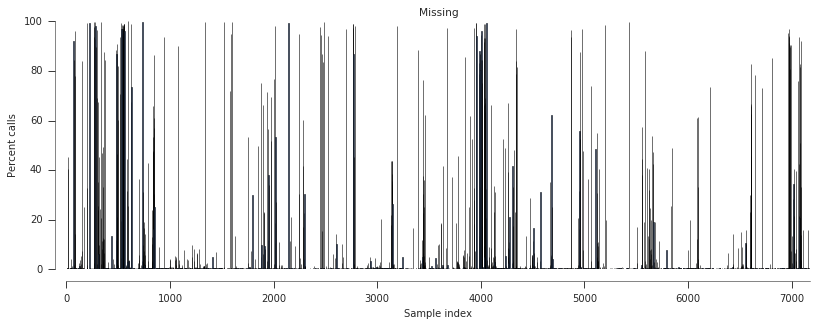

In [28]:
plot_genotype_frequency(pc_missing, 'Missing')


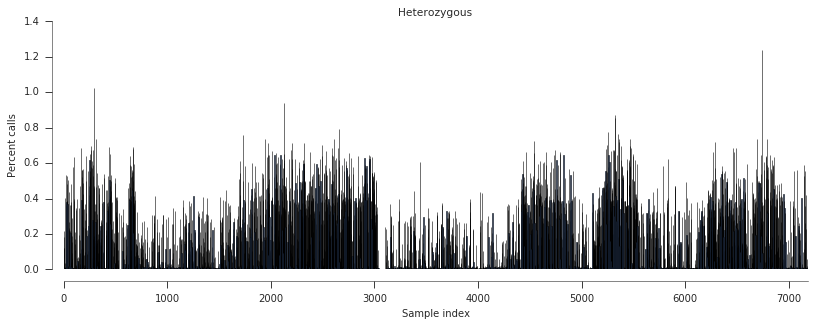

In [29]:
plot_genotype_frequency(pc_het, 'Heterozygous')


In [15]:
y['calldata']['genotype'].shape

(6051696, 7182, 2)

In [16]:
pass_coding_snps.shape

(6051696,)

In [61]:
start = time.time()
def is_het(genotype=np.array([0, 0], dtype='int8')):
    if genotype[0] != -1 and genotype[0] != genotype[1]:
        return(True)
    else:
        return(False)

v_is_het = np.vectorize(is_het)

v_is_het(genotypes.take(1000, 1))
end = time.time()
print(end - start)

11.95677375793457


In [ ]:
start = time.time()
def is_het(genotype=np.array([0, 0], dtype='int8')):
    if genotype[0] != -1 and genotype[0] != genotype[1]:
        return(True)
    else:
        return(False)

v_is_het = np.vectorize(is_het)

v_is_het(y['calldata']['GT'][:, 1000])
end = time.time()
print(end - start)

In [28]:
def is_het(gentype=np.array([0, 0], dtype='int8')):
    if gt.decode('ascii')[0] != '.' and gt.decode('ascii')[0] != gt.decode('ascii')[2]:
        return(True)
    else:
        return(False)

v_is_het = np.vectorize(is_het)

In [36]:
temp = y['calldata']['GT'][:, 1000]
temp2 = v_is_het(temp)

In [38]:
pd.value_counts(temp2)

False    5976488
True       75208
dtype: int64

In [ ]:
pd.value_counts(v_is_het(pd.value_counts(y['calldata']['GT'][:, sample_index])))

In [ ]:
temp2 = v_is_het(temp[])

In [39]:
def calc_proportion_het(sample=b'PD0658-C'):
    sample_index = np.where(y['samples'][:] == sample)[0][0]
    gt = y['calldata']['GT'][:, sample_index]
    num_het = np.count_nonzero(v_is_het())
    print(sample, sample_index)
    print(pd.value_counts(v_is_het(y['calldata']['GT'][:, sample_index])))

In [40]:
calc_proportion_het()

b'PD0658-C' 1000
False    5976488
True       75208
dtype: int64


In [66]:
y = h5py.File('%s/hdf5/Pf_60_npy_no_PID_PGT.h5' % output_dir, 'r')


In [67]:
(etl.wrap(
    np.unique(y['variants']['SNPEFF_EFFECT'], return_counts=True)
)
    .transpose()
    .pushheader('SNPEFF_EFFECT', 'number')
    .sort('number', reverse=True)
    .displayall()
)

SNPEFF_EFFECT,number
b'INTERGENIC',2795496
b'NON_SYNONYMOUS_CODING',1430363
b'SYNONYMOUS_CODING',641017
b'INTRON',449418
b'FRAME_SHIFT',444677
b'INTRAGENIC',89670
b'',70597
b'CODON_INSERTION',47470
b'CODON_DELETION',27491
b'CODON_CHANGE_PLUS_CODON_DELETION',17675


In [68]:
(etl.wrap(
    np.unique(y['variants']['CDS'], return_counts=True)
)
    .transpose()
    .pushheader('CDS', 'number')
    .sort('number', reverse=True)
    .displayall()
)

CDS,number
False,3383388
True,2668308


In [88]:
CDS = y['variants']['CDS'][:]
SNPEFF_EFFECT = y['variants']['SNPEFF_EFFECT'][:]
SNP = (y['variants']['VARIANT_TYPE'][:] == b'SNP')
INDEL = (y['variants']['VARIANT_TYPE'][:] == b'INDEL')


In [ ]:
np.unique(CDS[SNP], return_counts=True)

In [ ]:
2+2

In [85]:
y['variants']['VARIANT_TYPE']

<HDF5 dataset "VARIANT_TYPE": shape (6051696,), type "|S5">

In [89]:
pd.value_counts(INDEL)

False    3846585
True     2205111
dtype: int64

In [90]:
pd.crosstab(SNPEFF_EFFECT[SNP], CDS[SNP])

KeyboardInterrupt: 

In [ ]:
2+2

In [70]:
df = pd.DataFrame({'CDS': CDS, 'SNPEFF_EFFECT':SNPEFF_EFFECT})

In [75]:
writer = pd.ExcelWriter("/nfs/users/nfs_r/rp7/SNPEFF_for_Rob.xlsx")
pd.crosstab(SNPEFF_EFFECT, CDS).to_excel(writer)
writer.save()


In [73]:
pd.crosstab(SNPEFF_EFFECT, y['variants']['CHROM'])

col_0,b'Pf3D7_01_v3',b'Pf3D7_02_v3',b'Pf3D7_03_v3',b'Pf3D7_04_v3',b'Pf3D7_05_v3',b'Pf3D7_06_v3',b'Pf3D7_07_v3',b'Pf3D7_08_v3',b'Pf3D7_09_v3',b'Pf3D7_10_v3',b'Pf3D7_11_v3',b'Pf3D7_12_v3',b'Pf3D7_13_v3',b'Pf3D7_14_v3',b'Pf3D7_API_v3',b'Pf_M76611'
row_0,,,,,,,,,,,,,,,,
b'',5596,4486,4532,4303,2779,4566,7188,9494,4928,4304,4485,5923,5576,1779,236,422
b'CODON_CHANGE_PLUS_CODON_DELETION',538,836,844,1321,852,1183,1483,1282,888,1473,1430,1685,1846,1980,34,0
b'CODON_CHANGE_PLUS_CODON_INSERTION',509,648,733,1223,805,986,1306,1143,900,1120,1272,1650,1653,1668,21,1
b'CODON_DELETION',877,1094,1357,1669,1853,1567,1948,1822,1415,2762,2435,2559,2951,3139,41,2
b'CODON_INSERTION',1438,1863,2329,3186,2808,3105,3562,3342,2661,3463,3961,4658,5180,5838,73,3
b'EXON_DELETED',1,0,4,9,3,5,6,1,7,16,10,12,9,10,0,0
b'FRAME_SHIFT',19511,19580,18310,53868,12085,33194,51496,44289,23786,29154,28897,53743,32969,23176,560,59
b'INTERGENIC',112985,133602,147961,155345,126775,164228,170845,188646,216718,224002,235037,259684,316637,342596,353,82
b'INTRAGENIC',5967,7158,2931,11747,10181,5114,6986,2906,1290,3017,3837,10426,6371,11739,0,0


In [78]:
np.unique(y['variants']['svlen'], return_counts=True)

(array([-396, -378, -375, -370, -363, -359, -358, -354, -353, -351, -350,
        -349, -348, -347, -346, -345, -343, -342, -341, -340, -339, -338,
        -337, -336, -335, -334, -333, -332, -331, -330, -329, -328, -327,
        -326, -325, -324, -323, -322, -321, -320, -319, -318, -317, -316,
        -315, -314, -313, -312, -311, -310, -309, -308, -307, -306, -305,
        -304, -303, -302, -301, -300, -299, -298, -297, -296, -295, -294,
        -293, -292, -291, -290, -289, -288, -287, -286, -285, -284, -283,
        -282, -281, -280, -279, -278, -277, -276, -275, -274, -273, -272,
        -271, -270, -269, -268, -267, -266, -265, -264, -263, -262, -261,
        -260, -259, -258, -257, -256, -255, -254, -253, -252, -251, -250,
        -249, -248, -247, -246, -245, -244, -243, -242, -241, -240, -239,
        -238, -237, -236, -235, -234, -233, -232, -231, -230, -229, -228,
        -227, -226, -225, -224, -223, -222, -221, -220, -219, -218, -217,
        -216, -215, -214, -213, -212, 

In [32]:
y = h5py.File('%s/hdf5/Pf_60_npy_no_PID_PGT_10pc.h5.h5' % output_dir, 'r')
y

<HDF5 file "Pf_60_npy_no_PID_PGT_10pc.h5.h5" (mode r)>

In [33]:
# for field in y['variants'].keys():
for field in ['svlen']:
    print(field, np.unique(y['variants'][field], return_counts=True))

svlen (array([-375, -358, -354, -353, -348, -345, -340, -339, -337, -336, -335,
       -334, -332, -331, -330, -327, -324, -319, -317, -316, -315, -314,
       -313, -312, -311, -309, -308, -306, -305, -303, -302, -301, -300,
       -299, -298, -297, -296, -295, -294, -293, -292, -291, -290, -289,
       -288, -287, -286, -285, -284, -283, -282, -281, -280, -279, -278,
       -277, -276, -275, -274, -273, -272, -271, -270, -269, -268, -267,
       -266, -265, -264, -263, -262, -261, -260, -259, -258, -257, -256,
       -255, -254, -253, -252, -251, -250, -249, -248, -247, -246, -245,
       -244, -243, -242, -241, -240, -239, -238, -237, -236, -235, -234,
       -233, -232, -231, -230, -229, -228, -227, -226, -225, -224, -223,
       -222, -221, -220, -219, -218, -217, -216, -215, -214, -213, -212,
       -211, -210, -209, -208, -207, -206, -205, -204, -203, -202, -201,
       -200, -199, -198, -197, -196, -195, -194, -193, -192, -191, -190,
       -189, -188, -187, -186, -185, -184, -

In [11]:
!vcfnpy2hdf5 \
    --vcf {vcf_fn} \
    --input-dir {output_dir}/npy_no_PID_PGT_10pc \
    --output {output_dir}/hdf5/Pf_60_no_PID_PGT_10pc.h5 \
    --chunk-size 8388608 \
    --chunk-width 200 \
    --compression gzip \
    --compression-opts 1 \
    &>> {output_dir}/hdf5/Pf_60_no_PID_PGT_10pc.h5.log

!md5sum {output_dir}/hdf5/Pf_60_no_PID_PGT_10pc.h5 > {output_dir}/hdf5/Pf_60_no_PID_PGT_10pc.h5.md5 


/bin/sh: line 1: 14116 Segmentation fault      vcfnpy2hdf5 --vcf /lustre/scratch109/malaria/rp7/data/methods-dev/builds/Pf6.0/20161125_Pf60_final_vcfs/vcf/Pf_60_Pf_M76611.final.vcf.gz --input-dir /lustre/scratch111/malaria/rp7/data/methods-dev/builds/Pf6.0/20161127_HDF5_build/npy_subset --output /lustre/scratch111/malaria/rp7/data/methods-dev/builds/Pf6.0/20161127_HDF5_build/hdf5/Pf_60_subset_10pc.h5 --chunk-size 8388608 --chunk-width 200 --compression gzip --compression-opts 1 &>>/lustre/scratch111/malaria/rp7/data/methods-dev/builds/Pf6.0/20161127_HDF5_build/hdf5/Pf_60_subset_10pc.h5.log


In [10]:
!vcfnpy2hdf5 \
    --vcf {vcf_fn} \
    --input-dir {output_dir}/npy_subset_1pc \
    --output {output_dir}/hdf5/Pf_60_subset_1pc.h5 \
    --chunk-size 8388608 \
    --chunk-width 200 \
    --compression gzip \
    --compression-opts 1 \
    &>> {output_dir}/hdf5/Pf_60_subset_1pc.h5.log

!md5sum {output_dir}/hdf5/Pf_60_subset_1pc.h5 > {output_dir}/hdf5/Pf_60_subset_1pc.h5.md5 


In [11]:
!vcfnpy2hdf5 \
    --vcf {vcf_fn} \
    --input-dir {output_dir}/npy_subset \
    --output {output_dir}/hdf5/Pf_60_subset_10pc.h5 \
    --chunk-size 8388608 \
    --chunk-width 200 \
    --compression gzip \
    --compression-opts 1 \
    &>> {output_dir}/hdf5/Pf_60_subset_10pc.h5.log

!md5sum {output_dir}/hdf5/Pf_60_subset_10pc.h5 > {output_dir}/hdf5/Pf_60_subset_10pc.h5.md5 


/bin/sh: line 1: 14116 Segmentation fault      vcfnpy2hdf5 --vcf /lustre/scratch109/malaria/rp7/data/methods-dev/builds/Pf6.0/20161125_Pf60_final_vcfs/vcf/Pf_60_Pf_M76611.final.vcf.gz --input-dir /lustre/scratch111/malaria/rp7/data/methods-dev/builds/Pf6.0/20161127_HDF5_build/npy_subset --output /lustre/scratch111/malaria/rp7/data/methods-dev/builds/Pf6.0/20161127_HDF5_build/hdf5/Pf_60_subset_10pc.h5 --chunk-size 8388608 --chunk-width 200 --compression gzip --compression-opts 1 &>>/lustre/scratch111/malaria/rp7/data/methods-dev/builds/Pf6.0/20161127_HDF5_build/hdf5/Pf_60_subset_10pc.h5.log


In [11]:
!vcfnpy2hdf5 \
    --vcf {vcf_fn} \
    --input-dir {output_dir}/npy_subset \
    --output {output_dir}/hdf5/Pf_60_subset_10pc.h5 \
    --chunk-size 8388608 \
    --chunk-width 200 \
    --compression gzip \
    --compression-opts 1 \
    &>> {output_dir}/hdf5/Pf_60_subset_10pc.h5.log

!md5sum {output_dir}/hdf5/Pf_60_subset_10pc.h5 > {output_dir}/hdf5/Pf_60_subset_10pc.h5.md5 


/bin/sh: line 1: 14116 Segmentation fault      vcfnpy2hdf5 --vcf /lustre/scratch109/malaria/rp7/data/methods-dev/builds/Pf6.0/20161125_Pf60_final_vcfs/vcf/Pf_60_Pf_M76611.final.vcf.gz --input-dir /lustre/scratch111/malaria/rp7/data/methods-dev/builds/Pf6.0/20161127_HDF5_build/npy_subset --output /lustre/scratch111/malaria/rp7/data/methods-dev/builds/Pf6.0/20161127_HDF5_build/hdf5/Pf_60_subset_10pc.h5 --chunk-size 8388608 --chunk-width 200 --compression gzip --compression-opts 1 &>>/lustre/scratch111/malaria/rp7/data/methods-dev/builds/Pf6.0/20161127_HDF5_build/hdf5/Pf_60_subset_10pc.h5.log


In [9]:
!{output_dir}/scripts/vcfnp_concat.sh {vcf_fn} {output_dir}/hdf5/Pf_60

+ set -e
+ set -o pipefail
+ vcf=/lustre/scratch109/malaria/rp7/data/methods-dev/builds/Pf6.0/20161125_Pf60_final_vcfs/vcf/Pf_60_Pf_M76611.final.vcf.gz
+ outbase=/lustre/scratch111/malaria/rp7/data/methods-dev/builds/Pf6.0/20161127_HDF5_build/hdf5/Pf_60
+ inputs=/lustre/scratch111/malaria/rp7/data/methods-dev/builds/Pf6.0/20161127_HDF5_build/npy
+ output=/lustre/scratch111/malaria/rp7/data/methods-dev/builds/Pf6.0/20161127_HDF5_build/hdf5/Pf_60.h5
+ log=/lustre/scratch111/malaria/rp7/data/methods-dev/builds/Pf6.0/20161127_HDF5_build/hdf5/Pf_60.h5.log
+ '[' -f /lustre/scratch111/malaria/rp7/data/methods-dev/builds/Pf6.0/20161127_HDF5_build/hdf5/Pf_60.h5.md5 ']'
++ date
+ echo Sun Nov 27 10:53:45 GMT 2016 building
+ vcfnpy2hdf5 --vcf /lustre/scratch109/malaria/rp7/data/methods-dev/builds/Pf6.0/20161125_Pf60_final_vcfs/vcf/Pf_60_Pf_M76611.final.vcf.gz --input-dir /lustre/scratch111/malaria/rp7/data/methods-dev/builds/Pf6.0/20161127_HDF5_build/npy --output /lustre/scratch111/malaria/rp7/da

In [6]:
fo = open("%s/scripts/vcfnp_concat.sh" % output_dir, 'w')
print('''#!/bin/bash

set -x
set -e
set -o pipefail

vcf=$1
outbase=$2
# inputs=${vcf}.vcfnp_cache
inputs=%s/npy
output=${outbase}.h5

log=${output}.log

if [ -f ${output}.md5 ]
then
    echo $(date) skipping $chrom >> $log
else
    echo $(date) building $chrom > $log
    vcfnpy2hdf5 \
        --vcf $vcf \
        --input-dir $inputs \
        --output $output \
        --chunk-size 8388608 \
        --chunk-width 200 \
        --compression gzip \
        --compression-opts 1 \
        &>> $log
        
    md5sum $output > ${output}.md5 
fi''' % (
        output_dir,
        )
      , file=fo)
fo.close()

#     nv=$(ls -1 ${inputs}/v* | wc -l)
#     nc=$(ls -1 ${inputs}/c* | wc -l)
#     echo variants files $nv >> $log
#     echo calldata files $nc >> $log
#     if [ "$nv" -ne "$nc" ]
#     then
#         echo missing npy files
#         exit 1
#     fi


# Copy files to /nfs

In [3]:
!cp {output_dir}/hdf5/Pf_60_npy_PID_a12.h5 {nfs_final_hdf5_dir}/Pf_60.h5
!cp {output_dir}/hdf5/Pf_60_npy_PID_a12.h5.md5 {nfs_final_hdf5_dir}/Pf_60.h5.md5
